In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics import tsaplots

#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Import Data

In [2]:
# import data
path = 'data\\processed\\df_quarter_roe_average_08_09.csv'
key_path = 'data\\processed\\df_price07_18.csv'
training_price_path = 'data\\processed\\df_price07_18.csv'
dividend_path = 'data\\processed\\df_monthly_div_07_18.csv'

df = pd.read_csv(path)
df.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df.index = df['Stock']
df.drop('Stock', axis=1, inplace = True)

df_key = pd.read_csv(key_path)
df_key.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_key['Stock'].str.split('_', expand=True)

df_key['symbol'] = new[0]
df_key['company'] = new[1]
df_key.index = df_key['symbol']
df_key = df_key[['symbol', 'company']]
df_key.sort_index(inplace=True)

df_price = pd.read_csv(key_path)
df_price.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price['Stock'].str.split('_', expand=True)
df_price['symbol'] = new[0]
df_price.index = df_price['symbol']
df_price.drop(['Stock', 'symbol'], axis=1, inplace = True)


df_div = pd.read_csv(dividend_path)
df_div.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div.index = df_div['Stock']
df_div.drop('Stock', axis=1, inplace = True)

## Limit stocks to SP500 that traded daily throughout the duration

In [3]:
# define indices

idx_key = df_key.index
idx = df.index
idx_div = df_div.index

# drop stocks from eps dataframe

idx_diff1 = idx.difference(idx_key)
df.drop(idx_diff1, inplace=True)
print('df shape: {}'.format(df.shape))

# drop stocks from dividend

idx_diff2 = idx_div.difference(idx_key)
df_div.drop(idx_diff2, inplace=True)
print('df_div shape: {}'.format(df_div.shape))

df shape: (300, 2)
df_div shape: (355, 108)


In [4]:
df.drop(['BBT', 'CELG', 'JEC', 'NEM', 'STI', 'XRX'], inplace=True)

new_idx_df = df.index
new_idx_div = df_div.index

idx_diff3 = new_idx_div.difference(new_idx_df)
df_div.drop(idx_diff3, inplace=True)
print('df shape: {}'.format(df.shape))
print('df_div shape: {}'.format(df_div.shape))

df shape: (294, 2)
df_div shape: (294, 108)


## Exploratory Scatterplot

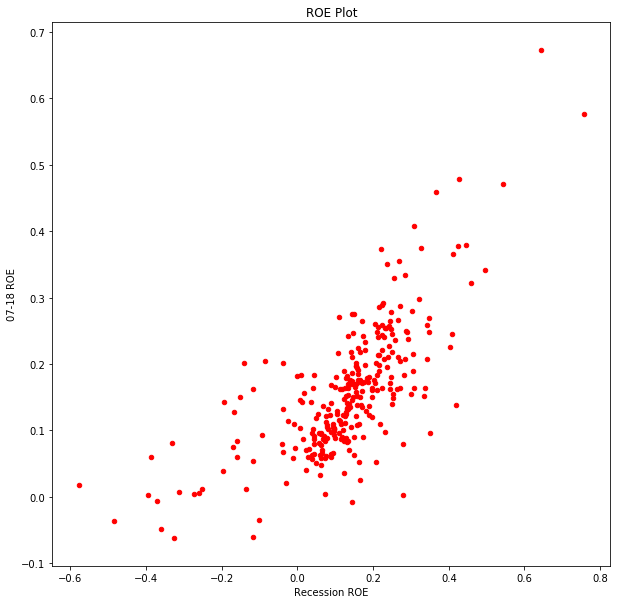

In [5]:
# plot

df.plot(kind='scatter', x='Recession ROE', y='07-18 ROE', title='ROE Plot', figsize=(10,10), color='r')

## Implementing Hypothesis - ROE

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


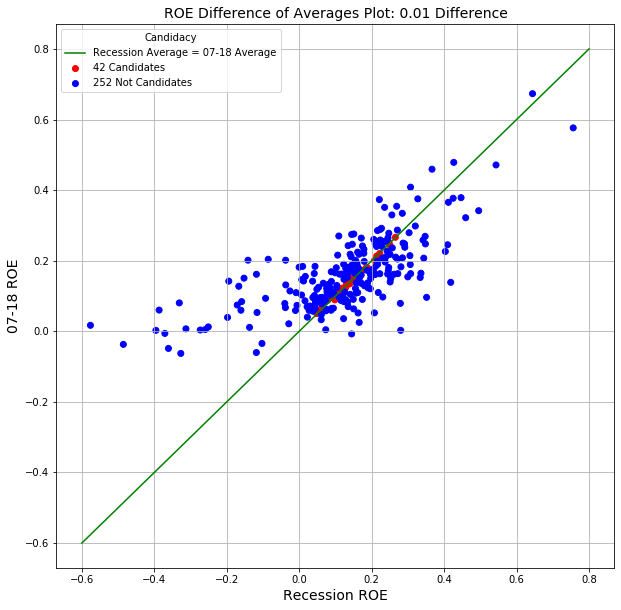

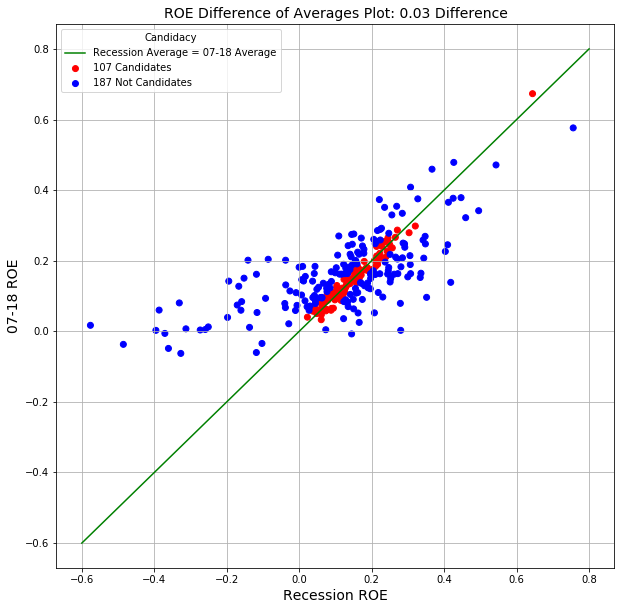

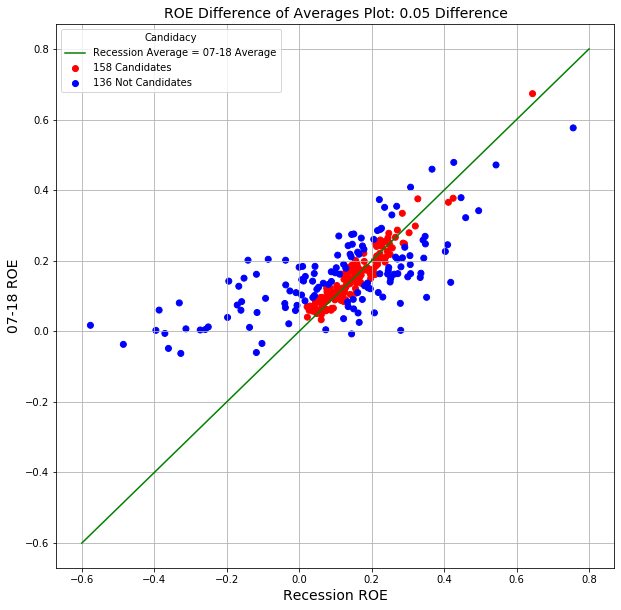

In [6]:
# define colors assignment

colors = {1:'red', 0:'blue'}
sub_title_font =14
legend_font =8
axis_font = 10
x = np.linspace(-0.6, 0.8, 100)
y=x

for diff in [0.01, 0.03, 0.05]:
    df['hypothesis']=np.where(abs(df['Recession ROE']-df['07-18 ROE']) <= diff, 1, 0)

    df_cand = df[df['hypothesis']==1]
    df_not = df[df['hypothesis']==0]
    
    df_cand['colors'] = 'red'
    df_not['colors'] = 'blue'
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    cand = ax.scatter(df_cand['Recession ROE'], df_cand['07-18 ROE'], c=df_cand.colors, label='{} Candidates'.format(len(df_cand.index)))
    not_cand = ax.scatter(df_not['Recession ROE'], df_not['07-18 ROE'], c=df_not.colors, label='{} Not Candidates'.format(len(df_not.index)))
    line = ax.plot(x, y, c="green", label='Recession Average = 07-18 Average')

    plt.xlabel('Recession ROE', fontsize=sub_title_font)
    plt.ylabel('07-18 ROE', fontsize=sub_title_font)
    plt.title('ROE Difference of Averages Plot: {} Difference'.format(diff), fontsize=sub_title_font)
    ax.tick_params(axis="x", labelsize=axis_font)
    ax.tick_params(axis="y", labelsize=axis_font)

    plt.grid(which='major')
    ax.legend(loc = 'upper left', title='Candidacy')
    plt.show()

## Filter stocks to ideal Candidate pool

### Let's pick the top 20% of resistant stocks for our pool

In [7]:
# build candidate pool from EPS

ratio = int(round(len(df.index)*0.2))
df_cand = df
df_cand['difference'] = abs(df['Recession ROE']-df['07-18 ROE'])
df_cand.sort_values(by=['difference'], inplace=True)
df_cand = df_cand.iloc[0:ratio, [0, 1, 3]]

In [8]:
# sort stocks by difference between average and recession eps
# 20% smallest differences become candidate stocks

ratio = int(round(len(df.index)*0.2))
df['difference'] = abs(df['Recession ROE'] - df['07-18 ROE'])
df.sort_values(by=['difference'], inplace=True)
df['colors'] = ''

df_cand = df.iloc[0:ratio, :]
df_not = df.iloc[ratio:, :]

df_cand['colors'] = 'red'
df_not['colors'] = 'blue'

print('Candidate df shape: {}'.format(df_cand.shape))
print('Not Candidate df shape: {}'.format(df_not.shape))

Candidate df shape: (59, 5)
Not Candidate df shape: (235, 5)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


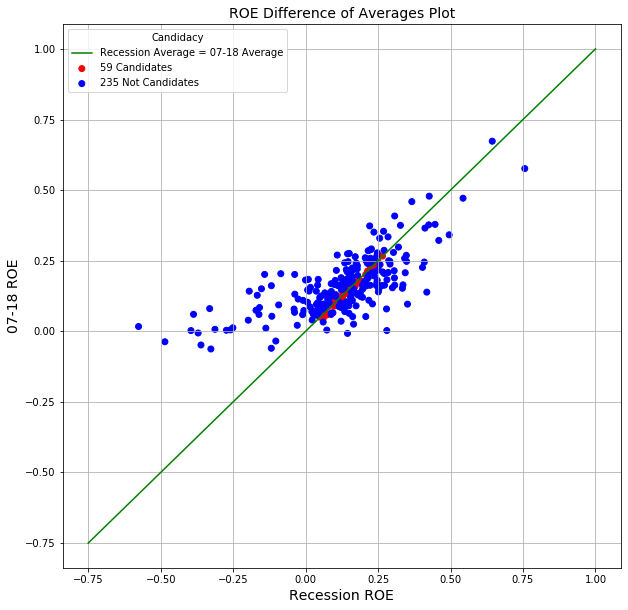

In [9]:
# plot metric decision boundary
sub_title_font =14
legend_font =8
axis_font = 10
x = np.linspace(-0.75, 1, 100)
y=x

fig, ax = plt.subplots(1, 1, figsize=(10,10))
cand = ax.scatter(df_cand['Recession ROE'], df_cand['07-18 ROE'], c=df_cand.colors, label='{} Candidates'.format(len(df_cand.index)))
not_cand = ax.scatter(df_not['Recession ROE'], df_not['07-18 ROE'], c=df_not.colors, label='{} Not Candidates'.format(len(df_not.index)))
line = ax.plot(x, y, c="green", label='Recession Average = 07-18 Average')

plt.xlabel('Recession ROE', fontsize=sub_title_font)
plt.ylabel('07-18 ROE', fontsize=sub_title_font)
plt.title('ROE Difference of Averages Plot', fontsize=sub_title_font)
ax.tick_params(axis="x", labelsize=axis_font)
ax.tick_params(axis="y", labelsize=axis_font)

plt.grid(which='major')
ax.legend(loc = 'upper left', title='Candidacy')
plt.show()

### Print list of Candidate Stocks

In [10]:
df_cand.sort_index(inplace=True)
for i in df_cand.index:
    print(i, df_key.loc[i, 'company'])

AFL AFLAC INC
AIZ ASSURANT INC
AJG GALLAGHER ARTHUR J & CO
AKAM AKAMAI TECHNOLOGIES INC
AME AMETEK INC NEW
AMGN AMGEN INC
ANSS ANSYS INC
BLL BALL CORP
CAH CARDINAL HEALTH INC
CERN CERNER CORP
CINF CINCINNATI FINANCIAL CORP
CMS C M S ENERGY CORP
CVS CVS CORP
DGX QUEST DIAGNOSTICS INC
DHR DANAHER CORP
DTE D T E ENERGY CO
DUK DUKE ENERGY CORP
EBAY EBAY INC
ED CONSOLIDATED EDISON INC
EFX EQUIFAX INC
EMR EMERSON ELECTRIC CO
ETN EATON CORP
EXPD EXPEDITORS INTERNATIONAL WA INC
FRT FEDERAL REALTY INVESTMENT TRUST
HAS HASBRO INC
HOG HARLEY DAVIDSON INC
HST HOST HOTELS & RESORTS INC
HUM HUMANA INC
ISRG INTUITIVE SURGICAL INC
JNPR JUNIPER NETWORKS INC
KO COCA COLA CO
KSS KOHLS CORP
LNT ALLIANT ENERGY CORP
MAC MACERICH CO
MET METLIFE INC
NFLX NETFLIX INC
NSC NORFOLK SOUTHERN CORP
NTRS NORTHERN TRUST CORP
PCAR PACCAR INC
PKI PERKINELMER INC
PWR QUANTA SERVICES INC
PXD PIONEER NATURAL RESOURCES CO
QCOM QUALCOMM INC
RCL ROYAL CARIBBEAN CRUISES LTD
REG REGENCY CENTERS
RJF RAYMOND JAMES FINANCIAL INC
R

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Find Returns for Control and Alternative

In [11]:
#update indices

idx_price = df_price.index
idx_cand = df_cand.index
idx_not = df_not.index

cand_diff = idx_price.difference(idx_cand)
df_cand_price = df_price.drop(cand_diff)

not_diff = idx_price.difference(idx_not)
df_not_price = df_price.drop(not_diff)

new_idx_div = df_div.index

In [12]:
# monthly returns

start_dates = ['2010-01-04', '2010-02-01', '2010-03-01', '2010-04-01', '2010-05-03', '2010-06-01', 
              '2010-07-01', '2010-08-02', '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01', 
              '2011-01-03', '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-02', '2011-06-01', 
              '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-03', '2011-11-01', '2011-12-01', 
              '2012-01-03', '2012-02-01', '2012-03-01', '2012-04-02', '2012-05-01', '2012-06-01', 
              '2012-07-02', '2012-08-01', '2012-09-04', '2012-10-01', '2012-11-01', '2012-12-03',
              '2013-01-02', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-03', 
              '2013-07-01', '2013-08-01', '2013-09-03', '2013-10-01', '2013-11-01', '2013-12-02', 
              '2014-01-02', '2014-02-03', '2014-03-03', '2014-04-01', '2014-05-01', '2014-06-02', 
              '2014-07-01', '2014-08-01', '2014-09-02', '2013-10-01', '2014-11-03', '2014-12-01', 
              '2015-01-02', '2015-02-02', '2015-03-02', '2015-04-01', '2015-05-01', '2015-06-01',
              '2015-07-01', '2015-08-03', '2015-09-01', '2015-10-01', '2015-11-02', '2015-12-01', 
              '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01', 
              '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01', '2016-12-01', 
              '2017-01-03', '2017-02-01', '2017-03-01', '2017-04-03', '2017-05-01', '2017-06-01', 
              '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-02', '2017-11-01', '2017-12-01', 
              '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-01', '2018-06-01', 
              '2018-07-02', '2018-08-01', '2018-09-04', '2018-10-01', '2018-11-01', '2018-12-03']

end_dates = ['2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-28', '2010-06-30', 
            '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', 
            '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', 
            '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', 
            '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', 
            '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31', 
            '2013-01-31', '2013-02-28', '2013-03-28', '2013-04-30', '2013-05-31', '2013-06-28', 
            '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31', '2013-11-29', '2013-12-31', 
            '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-30', '2014-06-30', 
            '2014-07-31', '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28', '2014-12-31', 
            '2015-01-30', '2015-02-27', '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30', 
            '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30', '2015-12-31', 
            '2016-01-29', '2016-02-29', '2016-03-31', '2016-04-29', '2016-05-31', '2016-06-30', 
            '2016-07-29', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-30', 
            '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30', 
            '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30', '2017-12-29', 
            '2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30', '2018-05-31', '2018-06-29', 
            '2018-07-31', '2018-08-31', '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-31']

# function to validate lists above

def list_diff(list1, list2):
    out = [item for item in list1 if not item in list2]
    return out

# validate start dates list

print('Missing Start Dates: {}'.format(list_diff(start_dates, list(df_price.columns))))

# validate end dates list

print('Missing End Dates: {}'.format(list_diff(end_dates, list(df_price.columns))))



# initialize risk free rates for each year
# deannualize 2010-2018 from the start of each year
# keep 2019 as normal

rfr10 = (1+0.0013)**(1/3) - 1
rfr11 = (1+0.0005)**(1/3) - 1
rfr12 = (1+0.0011)**(1/3) - 1
rfr13 = (1+0.00075)**(1/3) - 1
rfr14 = (1+0.0004)**(1/3) - 1
rfr15 = (1+0.0004)**(1/3) - 1
rfr16 = (1+0.0035)**(1/3) - 1
rfr17 = (1+0.0099)**(1/3) - 1
rfr18 = (1+0.0185)**(1/3) - 1

def create_returns(dataframe):
    temp_returns = pd.DataFrame(index=dataframe.index)
    
    for start, end in zip(start_dates, end_dates):
        temp_returns[end] = df_price[end] - df_price[start]

    idx_div_diff = new_idx_div.difference(dataframe.index)
    temp_div = df_div.drop(idx_div_diff) 
    total_returns = temp_returns + temp_div
    percent_returns = pd.DataFrame(index=dataframe.index)
    
    for start, end in zip(start_dates, end_dates):
        percent_returns[end] = total_returns[end]/df_price[start]
    #
    actual_returns = pd.DataFrame(index = dataframe.index, columns = percent_returns.columns)
    
    actual_returns.iloc[:, 0:12] = percent_returns.iloc[:, 0:12] - rfr10
    actual_returns.iloc[:, 12:24] = percent_returns.iloc[:, 12:24] - rfr11
    actual_returns.iloc[:, 24:36] = percent_returns.iloc[:, 24:36] - rfr12
    actual_returns.iloc[:, 36:48] = percent_returns.iloc[:, 36:48] - rfr13
    actual_returns.iloc[:, 48:60] = percent_returns.iloc[:, 48:60] - rfr14
    actual_returns.iloc[:, 60:72] = percent_returns.iloc[:, 60:72] - rfr15
    actual_returns.iloc[:, 72:84] = percent_returns.iloc[:, 72:84] - rfr16
    actual_returns.iloc[:, 84:96] = percent_returns.iloc[:, 84:96] - rfr17
    actual_returns.iloc[:, 96:108] = percent_returns.iloc[:, 96:108] - rfr18
    
    actual_returns = actual_returns.astype(float)
    return actual_returns

Missing Start Dates: []
Missing End Dates: []


In [13]:
# create returns

df_cand_returns = create_returns(df_cand)
df_not_returns = create_returns(df_not)

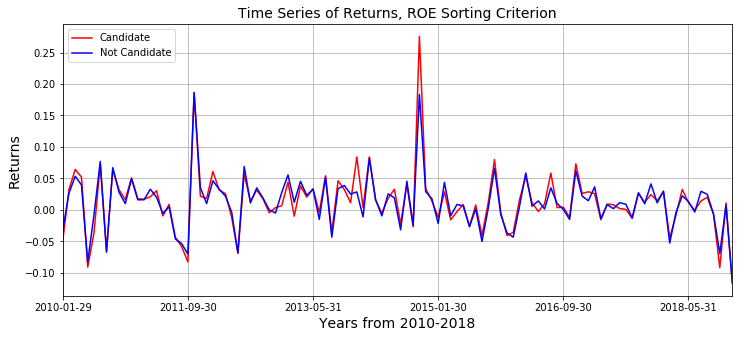

In [14]:
# plot returns

cand_series = df_cand_returns.mean(axis =0)
not_series = df_not_returns.mean(axis = 0)

plt.figure(figsize = (12,5))
plt.title('Time Series of Returns, ROE Sorting Criterion', fontsize = 14)
plt.xlabel('Years from 2010-2018', fontsize = 14)
plt.ylabel('Returns', fontsize = 14)

ax1 = cand_series.plot(color = 'red', grid = True, label = 'Candidate')
ax2 = not_series.plot(color = 'blue', grid = True, label = 'Not Candidate')

h1, l1 = ax1.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()